In [11]:
import os
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import ruptures as rpt

In [12]:
def statistical_features(arr):
    vmin = np.amin(arr)
    vmax = np.amax(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    return vmin, vmax, mean, std

def shape_features(arr):
    skewness = skew(arr)
    kurt = kurtosis(arr)
    return skewness, kurt

In [13]:
user = 'CE'

## Pre-processing

In [14]:
import_path = f'{user}'
export_path = f'{user}'

rightEDAdatapath  = f'{import_path}/EDA.csv'
rightHRdatapath   = f'{import_path}/HR.csv'
rightTEMPdatapath = f'{import_path}/TEMP.csv'

In [15]:
rightHRdatapath = np.loadtxt(rightHRdatapath, delimiter = ',')
rightHRdatapath = np.repeat(rightHRdatapath, 4)
np.savetxt('hr_new.csv', rightHRdatapath, delimiter = ',')

In [16]:
edat =  pd.read_csv(f'{user}/EDA.csv',  header = 2,  names = ['EDA'])
hrt =   pd.read_csv(f'hr_new.csv',      header = 12, names = ['HR'])
tempt = pd.read_csv(f'{user}/Temp.csv', header = 2,  names = ['TEMP'])
gt =    pd.read_csv(f'{user}/EDA.csv',  nrows  = 1)

In [17]:
reference_time = gt.iloc[0,0]
min_len = min(len(edat), len(hrt), len(tempt))

eda = edat.iloc[:min_len, 0]
hrt = hrt.iloc[:min_len, 0]
tempt = tempt.iloc[:min_len, 0]
df_original = pd.concat([eda, hrt, tempt], axis = 1)

In [18]:
array = df_original.values
data = pd.DataFrame(array)
data.columns = ['EDA','HR','temp']

cols = [
    'EDA_Mean','EDA_Min','EDA_Max','EDA_Std', 'EDA_Kurtosis', 'EDA_Skew','EDA_Num_Peaks','EDA_Amphitude','EDA_Duration',
    'HR_Mean','HR_Min','HR_Max','HR_Std','HR_RMS','temp_Mean', 'temp_Min','temp_Max','temp_Std'
]
df_features = pd.DataFrame(columns=cols)

index = 0

for i in range(0,len(data['EDA']), 20):
    df_partial = data.iloc[i:i+40,]
    plen = len(df_partial['EDA'])
    
    if plen < 40:
        continue
    
    eda = df_partial['EDA'].values
    hr = df_partial['HR'].values
    temp = df_partial['temp'].values

    eda_min, eda_max, eda_mean, eda_std = statistical_features(eda)
    hr_min, hr_max, hr_mean, hr_std = statistical_features(hr)
    temp_min, temp_max, temp_mean, temp_std = statistical_features(temp)
    eda_skew, eda_kurtosis = shape_features(eda)
    
    hr_rms = np.sqrt(np.mean(np.square(np.ediff1d(hr))))
    temp_rms= np.sqrt(np.mean(np.square(np.ediff1d(temp))))

    peaks,properties = find_peaks(eda, width=5)
    num_Peaks = len(peaks)
    
    prominences = np.array(properties['prominences'])
    widths = np.array(properties['widths'])
    amphitude = np.sum(prominences)
    duration = np.sum(widths)

    df_features.loc[index] = [eda_mean, eda_min, eda_max, eda_std, eda_kurtosis, eda_skew, num_Peaks, amphitude, duration, hr_mean, hr_min, hr_max, hr_std,hr_rms, temp_mean, temp_min, temp_max, temp_std]

    index = index+1

In [19]:
cols = list(map(str, range(30, 0, -1)))
df_lag_features = pd.DataFrame(columns=cols)
df_lag_features = pd.concat([
    df_features['HR_Mean'].shift(10),  df_features['HR_Mean'].shift(9),    df_features['HR_Mean'].shift(8),
    df_features['HR_Mean'].shift(7),   df_features['HR_Mean'].shift(6),    df_features['HR_Mean'].shift(5),
    df_features['HR_Mean'].shift(4),   df_features['HR_Mean'].shift(3),    df_features['HR_Mean'].shift(2),
    df_features['HR_Mean'].shift(1),   df_features['temp_Mean'].shift(10), df_features['temp_Mean'].shift(9),
    df_features['temp_Mean'].shift(8), df_features['temp_Mean'].shift(7),  df_features['temp_Mean'].shift(6),
    df_features['temp_Mean'].shift(5), df_features['temp_Mean'].shift(4),  df_features['temp_Mean'].shift(3),
    df_features['temp_Mean'].shift(2), df_features['temp_Mean'].shift(1),  df_features['EDA_Mean'].shift(10),
    df_features['EDA_Mean'].shift(9),  df_features['EDA_Mean'].shift(8),   df_features['EDA_Mean'].shift(7),
    df_features['EDA_Mean'].shift(6),  df_features['EDA_Mean'].shift(5),   df_features['EDA_Mean'].shift(4),
    df_features['EDA_Mean'].shift(3),  df_features['EDA_Mean'].shift(2),   df_features['EDA_Mean'].shift(1)], axis=1)
df_lag_features.columns = cols
df_lag_features = df_lag_features.dropna()

In [20]:
df_temp = df_features.iloc[30:3238, 0:31]
df_total = pd.concat([df_lag_features, df_temp], axis=1)

## Stress detection model

Random Forest

In [11]:
df_lag = pd.read_csv('combined_lagEDA.csv')
train_set = df_lag.iloc[:,0:48]
labels = df_lag.iloc[:,48:49]

In [21]:
df_lag = pd.read_csv('combined_lagEDA.csv')
train_set = df_lag.iloc[:,0:48]
labels = df_lag.iloc[:,48:49]

#Crear un clasificador de bosque aleatorio
clf = RandomForestClassifier(n_estimators=250,max_depth=40)   #mejorado

# Dividir nuestros datos
train, test, train_labels, test_labels = train_test_split(train_set, labels, test_size=0.33, random_state=30)

#Entrena el modelo usando los conjuntos de entrenamiento y_pred=clf.predict(X_test)
clf.fit(train, train_labels.values.ravel())

y_pred = clf.predict(test)

f1score   = f1_score        (test_labels, y_pred, average = 'macro')
recall    = recall_score    (test_labels, y_pred, average = 'macro')
precision = precision_score (test_labels, y_pred, average = 'macro')
accuracy  = accuracy_score  (test_labels, y_pred)

print('acc =', accuracy)
print('pre =', precision)
print('recall =', recall) 
print('f1 =', f1score)

acc = 0.9644509374239104
pre = 0.9616223184590721
recall = 0.9504552049787929
f1 = 0.9556448381636905


MLP

In [13]:
# Dividir nuestros datos
train, test, train_labels, test_labels = train_test_split(train_set, labels, test_size=0.33, random_state=30)

#Entrena el modelo usando los conjuntos de entrenamiento y_pred=clf.predict(X_test)
clf = MLPClassifier(hidden_layer_sizes=(300, 280), random_state=1, max_iter=600).fit(train, train_labels.values.ravel())

y_pred = clf.predict(test)

f1score   = f1_score        (test_labels, y_pred, average = 'macro')
recall    = recall_score    (test_labels, y_pred, average = 'macro')
precision = precision_score (test_labels, y_pred, average = 'macro')
accuracy  = accuracy_score  (test_labels, y_pred)

print('acc =', accuracy)
print('pre =', precision)
print('recall =', recall)
print('f1 =', f1score)

acc = 0.9079620160701242
pre = 0.8915115360901189
recall = 0.8876675133706907
f1 = 0.889307398204255


SVM LINEAL

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


    # Escalar los datos
scaler = StandardScaler()
scaled_train_set = scaler.fit_transform(train_set)

    # Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(scaled_train_set, labels, test_size=0.33, random_state=30)

    # Crear el modelo SVM con hiperparámetros ajustados
clf = SVC(kernel='rbf', C=10, gamma=0.1, random_state=30)

    # Entrenar el modelo
clf.fit(X_train, y_train)

    # Realizar predicciones
y_pred = clf.predict(X_test)

    # Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

    # Imprimir los resultados
print("\nResultados del modelo SVM:")
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision (Macro): {precision:.6f}")
print(f"Recall (Macro): {recall:.6f}")
print(f"F1 Score (Macro): {f1:.6f}")



C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Resultados del modelo SVM:
Accuracy: 0.819576
Precision (Macro): 0.790473
Recall (Macro): 0.780199
F1 Score (Macro): 0.784711


Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def gaussian_nb_predict(train_set, labels):
    # Escalar los datos
    scaler = StandardScaler()
    scaled_train_set = scaler.fit_transform(train_set)

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(scaled_train_set, labels, test_size=0.33, random_state=30)

    # Definir el modelo Gaussian Naive Bayes
    gnb_model = GaussianNB()

    # Entrenar el modelo
    gnb_model.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = gnb_model.predict(X_test)

    # Calcular las métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Imprimir los resultados
    print("\nResultados del modelo Gaussian Naive Bayes:")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Precision (Macro): {precision:.6f}")
    print(f"Recall (Macro): {recall:.6f}")
    print(f"F1 Score (Macro): {f1:.6f}")

    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = gaussian_nb_predict(train_set, labels)


Resultados del modelo Gaussian Naive Bayes:
Accuracy: 0.539323
Precision (Macro): 0.486367
Recall (Macro): 0.483251
F1 Score (Macro): 0.483988


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def knn_predict(train_set, labels, show_best_params=False):
    # Escalar los datos
    scaler = StandardScaler()
    scaled_train_set = scaler.fit_transform(train_set)

    # Dividir nuestros datos
    X_train, X_test, y_train, y_test = train_test_split(scaled_train_set, labels, test_size=0.33, random_state=30)

    # Entrenar el modelo KNN sin GridSearchCV
    knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
    knn_model.fit(X_train, y_train)

    # Predecir en los datos de prueba
    y_pred = knn_model.predict(X_test)

    # Calcular las métricas de rendimiento
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Imprimir los resultados con más decimales
    print("\nResultados del modelo K-Nearest Neighbors:")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Precision (Macro): {precision:.6f}")
    print(f"Recall (Macro): {recall:.6f}")
    print(f"F1 Score (Macro): {f1:.6f}")

    # Opción para mostrar hiperparámetros ajustados
    if show_best_params:
        print("\n**Búsqueda de Hiperparámetros**:")
        param_grid = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
        grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        print(f"Mejores Hiperparámetros: {grid_search.best_params_}")

    return accuracy, precision, recall, f1, knn_model

accuracy, precision, recall, f1, clf = knn_predict(train_set, labels)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



Resultados del modelo K-Nearest Neighbors:
Accuracy: 0.795228
Precision (Macro): 0.765881
Recall (Macro): 0.761437
F1 Score (Macro): 0.763522


Gaussian Process

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def gaussian_process_predict(train_set, labels):
    # Escalar los datos
    scaler = StandardScaler()
    scaled_train_set = scaler.fit_transform(train_set)

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(scaled_train_set, labels, test_size=0.33, random_state=30)

    # Definir el kernel para el Gaussian Process
    kernel = 1.0 * RBF(length_scale=1.0)

    # Crear el modelo Gaussian Process Classifier
    gpc = GaussianProcessClassifier(kernel=kernel, random_state=30)

    # Entrenar el modelo
    gpc.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = gpc.predict(X_test)

    # Calcular las métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Imprimir los resultados
    print("\nResultados del modelo Gaussian Process Classifier:")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Precision (Macro): {precision:.6f}")
    print(f"Recall (Macro): {recall:.6f}")
    print(f"F1 Score (Macro): {f1:.6f}")

    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = gaussian_process_predict(train_set, labels)


### Predicting the stress

In [22]:
df_total = df_total.dropna()
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(df_total.iloc[:,0:48])
data = pd.DataFrame(x_scaled)
data = data.fillna(0)

pred_t = clf.predict(data)
pred_t = pd.DataFrame(pred_t)
pred_t.columns=['pred']
pred_t.head(30)
pred_t.to_csv('pred'+user+'.csv')

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [23]:
df_total['pred'] = pred_t
df_total.to_csv('pred{user}.csv')

In [24]:
df_total['MA_3'] = np.ceil(df_total.iloc[:,48:49].rolling(window=31).mean())

### Change detection

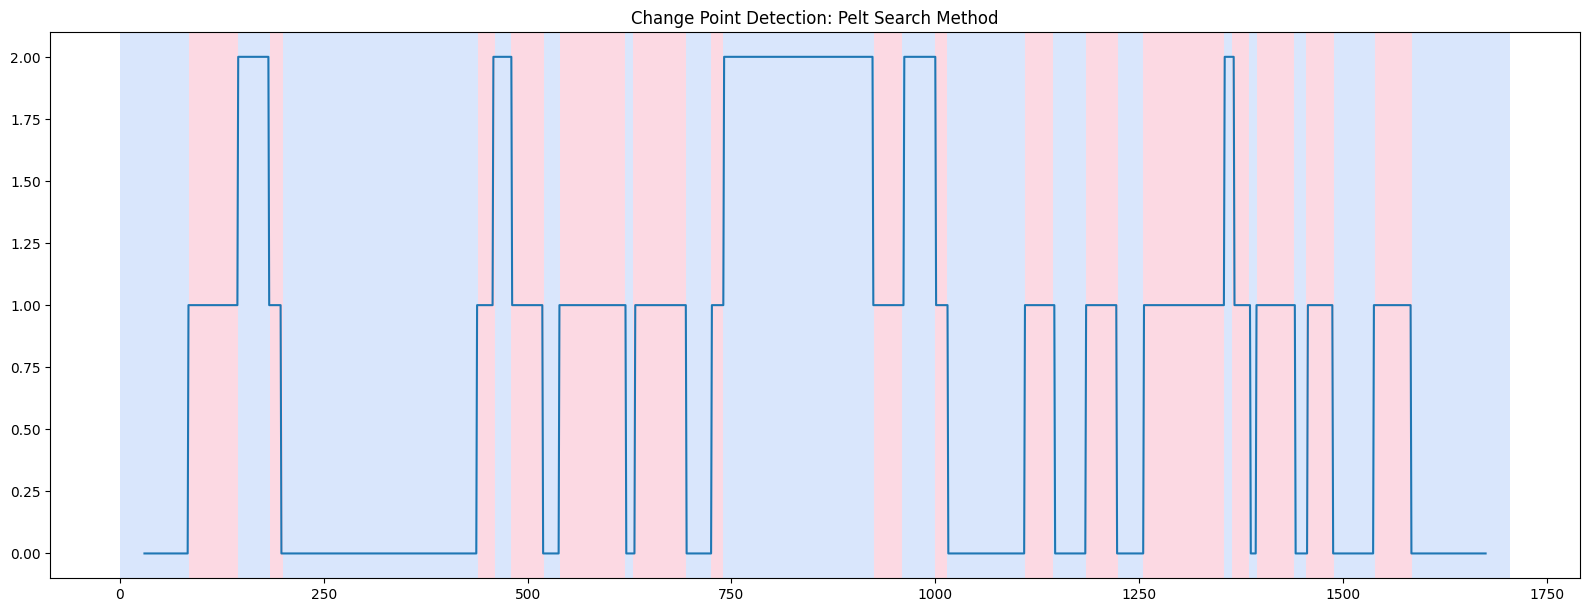

[0, 85, 145, 185, 200, 440, 460, 480, 520, 540, 620, 630, 695, 725, 740, 925, 960, 1000, 1015, 1110, 1145, 1185, 1225, 1255, 1355, 1365, 1385, 1395, 1440, 1455, 1490, 1540, 1585, 1706]


In [25]:
signal = df_total.iloc[:,49:50].values

algo = rpt.Window(model="l2", width=10).fit(signal)
result = algo.predict(n_bkps=60)

rpt.display(signal, result, figsize=(16, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()

result.insert(0, 0)
print(result)

### Generating the event by start and end epoch_times

In [26]:
temp_start = 0
temp_end = result[0]

stress = []
for i in range (len(result)-1):
    
    temp = df_total.iloc[result[i]:(result[i+1]-1), 49:50].mean()[0]
    
    if temp > 1.3:
        temp = 2.0
    elif temp >= .65:
        temp = 1
    else:
        temp = 0

    stress.append(temp)
    
df_temp = pd.DataFrame(columns=['start', 'end', 'stress'])
c = 0
for i in range(len(result)-1):
    stressLength = (result[i+1] - result[i]) / 12

    start_point  = result[i]
    end_point    = result[i + 1]
    stress_value = stress[i]
    
    if temp_end <= start_point:
        temp_end       = end_point
        df_temp.loc[c] = [start_point, end_point, stress_value]
        c = c +1

df_temp

,start,end,stress
0,0.0,85.0,0.0
1,85.0,145.0,1.0
2,145.0,185.0,2.0
3,185.0,200.0,1.0
4,200.0,440.0,0.0
5,440.0,460.0,1.0
6,460.0,480.0,2.0
7,480.0,520.0,1.0
8,520.0,540.0,0.0
9,540.0,620.0,1.0


## Change event time to datetime

In [27]:
stress_start = 0
stress_end = 0
tse = 0
previous_stress = -1

for index, row in df_temp.iterrows():

    if row['stress'] == previous_stress:
        stress_end = row['end']
    else:
        if(previous_stress != -1):
            start    = datetime.fromtimestamp(reference_time + (stress_start * 5))
            end      = datetime.fromtimestamp(reference_time + (stress_end * 5))
            timediff = end - start
            print('Prev:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)
        
        stress_start    = row['start']
        stress_end      = row['end']
        previous_stress = row['stress']
        
print('Final:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)

Prev: 0:07:05 19:00:04 19:07:09 0.0
Prev: 0:05:00 19:07:09 19:12:09 1.0
Prev: 0:03:20 19:12:09 19:15:29 2.0
Prev: 0:01:15 19:15:29 19:16:44 1.0
Prev: 0:20:00 19:16:44 19:36:44 0.0
Prev: 0:01:40 19:36:44 19:38:24 1.0
Prev: 0:01:40 19:38:24 19:40:04 2.0
Prev: 0:03:20 19:40:04 19:43:24 1.0
Prev: 0:01:40 19:43:24 19:45:04 0.0
Prev: 0:06:40 19:45:04 19:51:44 1.0
Prev: 0:00:50 19:51:44 19:52:34 0.0
Prev: 0:05:25 19:52:34 19:57:59 1.0
Prev: 0:02:30 19:57:59 20:00:29 0.0
Prev: 0:01:15 20:00:29 20:01:44 1.0
Prev: 0:15:25 20:01:44 20:17:09 2.0
Prev: 0:02:55 20:17:09 20:20:04 1.0
Prev: 0:03:20 20:20:04 20:23:24 2.0
Prev: 0:01:15 20:23:24 20:24:39 1.0
Prev: 0:07:55 20:24:39 20:32:34 0.0
Prev: 0:02:55 20:32:34 20:35:29 1.0
Prev: 0:03:20 20:35:29 20:38:49 0.0
Prev: 0:03:20 20:38:49 20:42:09 1.0
Prev: 0:02:30 20:42:09 20:44:39 0.0
Prev: 0:08:20 20:44:39 20:52:59 1.0
Prev: 0:00:50 20:52:59 20:53:49 2.0
Prev: 0:01:40 20:53:49 20:55:29 1.0
Prev: 0:00:50 20:55:29 20:56:19 0.0
Prev: 0:03:45 20:56:19 21:00